In [1]:
!pip install dlib opencv-python-headless torch torchvision tqdm numpy pandas matplotlib

In [2]:
# Mount Google Drive if needed (for file storage)
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
import os
from pathlib import Path
BASE_PATH = "/content/drive/MyDrive/ColabData"
os.makedirs(BASE_PATH, exist_ok=True)

SHAPE_PREDICTOR_PATH = Path(f"{BASE_PATH}/shape_predictor_68_face_landmarks.dat")
FOLDER_VIDEOS = Path(f"{BASE_PATH}/videos")
FOLDER_FEATURES_MOTION = Path(f"{BASE_PATH}/features")
FOLDER_VIDEOS_OF = Path(f"{BASE_PATH}/videos_of")

In [4]:
class OpticalFlowConstansts:
    USE_RAFT_LARGE = True

    PADDING_BOX_BOTTOM_FACE = 60
    VISUALIZE = False
    SAVE_OPTICAL_FLOW_VIDEO = True
    VIDEO_TEST = False
    # do not consider all the frames to lower the amount of computations
    KEEP_EVERY_NUM_FRAMES = 1
    VISUALIZE_EVERY_NUM_FRAMES = 2
    DOWNSAMPLE_RATE = 2

    AVERAGE_BY_WINDOW = False
    WINDOW_LENGTH = 2.0

In [5]:
import datetime
import timeit

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import torch
import torchvision.transforms as T
from torchvision.models.optical_flow import (
    raft_large,
    raft_small,
    Raft_Small_Weights,
    Raft_Large_Weights,
)
from tqdm import tqdm
import dlib

Device: cuda
Total number of videos: 1
File: video_presentation.mp4; File number 1 of 1
FPS: 30.0; Num frames: 257.0; duration: 8.57 s
Quality 1280 X 720


100%|██████████| 256/256 [02:28<00:00,  1.73it/s]


1

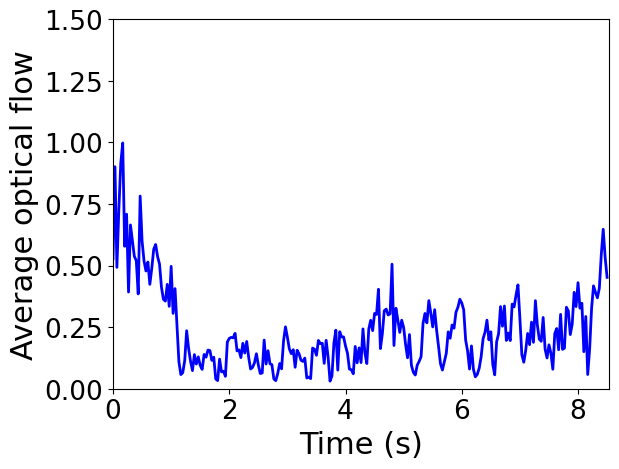

In [6]:
# face detector able to detect faces that are looking more or less to the camera
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(str(SHAPE_PREDICTOR_PATH))


def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(
                mean=0.5, std=0.5
            ),  # map [0, 1] into [-1, 1] substracting the mean and dividing by the std
        ]
    )
    batch = transforms(batch)
    return batch


device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print("Device: " + device)


if OpticalFlowConstansts.USE_RAFT_LARGE:
    model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=True).to(device)
else:
    model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=True).to(device)
model = model.eval()


# Open video file
def compute_motions(
    path: Path,
    current_num_file: int,
    tot_num_videos: int,
    start_time,
    initial_parent_folder: str,
) -> int:
    if path.is_dir():
        # scan the folder recursively
        for file in path.iterdir():
            current_num_file = compute_motions(
                file,
                current_num_file,
                tot_num_videos,
                start_time,
                initial_parent_folder,
            )
        return current_num_file

    current_num_file += 1

    # output path
    relative_pos_index = path.parts.index(initial_parent_folder)
    feature_path = FOLDER_FEATURES_MOTION.joinpath(
        *path.parts[relative_pos_index + 1 :]
    )
    output_of = FOLDER_VIDEOS_OF.joinpath( *path.parts[relative_pos_index + 1 :])
    output_of_filtered = output_of.parent.joinpath(output_of.name.split(".")[0]+"_filtered.mp4")
    output_aof_plot = output_of.parent.joinpath(output_of.name.split(".")[0]+"_aof.mp4")

    if not feature_path.parent.exists():
        os.makedirs(feature_path.parent)
    feature_path = feature_path.with_name(feature_path.name.split(".")[0] + "_RAFT")
    feature_path = feature_path.with_suffix(".csv")

    # features already computed for this video
    if feature_path.exists():
        return current_num_file



    # load video and metadata
    cap = cv2.VideoCapture(str(path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) // OpticalFlowConstansts.DOWNSAMPLE_RATE
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) // OpticalFlowConstansts.DOWNSAMPLE_RATE
    if current_num_file == 1:
        print(f"File: {path.name}; File number 1 of {tot_num_videos}")
    else:
        estimated_time_left = (
            (tot_num_videos - current_num_file + 1)
            * (timeit.default_timer() - start_time)
            / (current_num_file - 1)
        )
        print(
            f"File: {path.name}; File number {current_num_file} of {tot_num_videos}; Estimated time left:{datetime.timedelta(seconds=(int(estimated_time_left)))}"
        )
    print(f"FPS: {fps}; Num frames: {num_frames}; duration: {num_frames/fps:.2f} s")

    # create the output source
    if OpticalFlowConstansts.SAVE_OPTICAL_FLOW_VIDEO:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        output_video = cv2.VideoWriter(str(output_of), fourcc, fps, (width, height))
        output_video_filtered = cv2.VideoWriter(str(output_of_filtered), fourcc, fps, (width, height))
        frame_width, frame_height = 640, 480
        output_video_plot = cv2.VideoWriter(str(output_aof_plot), fourcc, fps, (frame_width, frame_height))

    min_pixel_magn = np.finfo(np.float64).max
    max_pixel_magn = np.finfo(np.float64).min

    list_magnitudes = []


    # Read the first frame and convert to grayscale
    ret, prev_frame = cap.read()
    print(f"Quality {prev_frame.shape[0]} X {prev_frame.shape[1]}")
    if OpticalFlowConstansts.DOWNSAMPLE_RATE != 1:
        prev_frame = cv2.GaussianBlur(
            prev_frame, (5, 5), 1 / (2 * OpticalFlowConstansts.DOWNSAMPLE_RATE)
        )  # kernel size and standard deviation
        prev_frame = cv2.resize(
            prev_frame,
            (
                prev_frame.shape[1] // OpticalFlowConstansts.DOWNSAMPLE_RATE,
                prev_frame.shape[0] // OpticalFlowConstansts.DOWNSAMPLE_RATE,
            ),
        )
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_frame = np.moveaxis(
        prev_frame, -1, 0
    )  # move from (W, H, C) to (C, W, H) compatible with PyTorch

    # process the remaining frames
    for num_frame in tqdm(
        range(1, int(num_frames), OpticalFlowConstansts.KEEP_EVERY_NUM_FRAMES)
    ):
        # for num_frame in range(
        #     1, int(num_frames), OpticalFlowConstansts.KEEP_EVERY_NUM_FRAMES
        # ):
        if not cap.isOpened():
            break

        # set the position to the next frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, num_frame)
        ret, frame = cap.read()
        if not ret:
            break

        # smooth and downsample
        if OpticalFlowConstansts.DOWNSAMPLE_RATE != 1:
            frame = cv2.GaussianBlur(
                frame, (5, 5), 1 / (2 * OpticalFlowConstansts.DOWNSAMPLE_RATE)
            )  # kernel size and standard deviation
            frame = cv2.resize(
                frame,
                (
                    frame.shape[1] // OpticalFlowConstansts.DOWNSAMPLE_RATE,
                    frame.shape[0] // OpticalFlowConstansts.DOWNSAMPLE_RATE,
                ),
            )

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # move from (W, H, C) to (C, W, H) compatible with PyTorch
        frame = np.moveaxis(frame, -1, 0)

        # Compute optical flow
        video_frames = preprocess(
            torch.stack([torch.from_numpy(prev_frame), torch.from_numpy(frame)])
        ).to(device)
        list_of_flows = model(video_frames[[0]], video_frames[[1]])
        predicted_flows = list_of_flows[-1]  # to shape shape = (N, 2, H, W) with N = 1
        predicted_flows = predicted_flows[0].cpu().detach().numpy()
        magnitude = np.sqrt(predicted_flows[0] ** 2 + predicted_flows[1] ** 2)

        min_pixel_magn = min(magnitude.min(), min_pixel_magn)
        max_pixel_magn = max(magnitude.max(), max_pixel_magn)


        if OpticalFlowConstansts.SAVE_OPTICAL_FLOW_VIDEO:
            # move to color representation
            global_min = 0
            global_max = 10.1 # computed in previous iterations
            magnitude_norm = np.clip(((magnitude - global_min) / (global_max - global_min)) * 255, 0, 255).astype(np.uint8)
            color_magnitude = cv2.applyColorMap(magnitude_norm, cv2.COLORMAP_CIVIDIS)
            output_video.write(color_magnitude)

        # Detect faces
        faces = detector(prev_gray)
        for face in faces:
            # Get facial landmarks
            landmarks = predictor(gray, face)

            # Mouth coordinates
            mouth_x1 = landmarks.part(4).x
            mouth_y1 = landmarks.part(51).y
            mouth_x2 = landmarks.part(12).x
            mouth_y2 = landmarks.part(8).y

            # Expand box
            padding = (
                OpticalFlowConstansts.PADDING_BOX_BOTTOM_FACE
                // OpticalFlowConstansts.DOWNSAMPLE_RATE
            )
            mouth_x1 -= padding
            mouth_y1 -= padding
            mouth_x2 += padding
            mouth_y2 += padding

            # Draw black box over mouth
            cv2.rectangle(
                magnitude, (mouth_x1, mouth_y1), (mouth_x2, mouth_y2), (0, 0, 0), -1
            )

        if OpticalFlowConstansts.SAVE_OPTICAL_FLOW_VIDEO:
            # move to color representation
            magnitude_norm = np.clip(((magnitude - global_min) / (global_max - global_min)) * 255, 0, 255).astype(np.uint8)
            color_magnitude = cv2.applyColorMap(magnitude_norm, cv2.COLORMAP_CIVIDIS)
            output_video_filtered.write(color_magnitude)




        list_magnitudes.append(np.average(magnitude))

        # show output
        if (
            OpticalFlowConstansts.VISUALIZE
            and (num_frame // OpticalFlowConstansts.KEEP_EVERY_NUM_FRAMES)
            % OpticalFlowConstansts.VISUALIZE_EVERY_NUM_FRAMES
            == 0
        ):
            print("Average magnitude: ", list_magnitudes[-1])
            fig, ax = plt.subplots()
            ax.imshow(magnitude)
            # ax.imshow(magnitude, vmin=0, vmax=180)
            ax.tick_params(
                axis="y", which="both", left=False, right=False, labelleft=False
            )
            ax.tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False
            )
            plt.tight_layout()
            plt.show()

        # update previous frame
        prev_gray = gray
        prev_frame = frame

    cap.release()
    if OpticalFlowConstansts.SAVE_OPTICAL_FLOW_VIDEO:
        output_video.release()
        output_video_filtered.release()

    magnitudes = np.array(list_magnitudes)

    #print(f"\n\n min pixel magn: {min_pixel_magn}")
    #print(f"\n\n max pixel magn: {max_pixel_magn}")


    if OpticalFlowConstansts.SAVE_OPTICAL_FLOW_VIDEO:
        fig, ax = plt.subplots(figsize=(frame_width/100.0, frame_height/100.0))  # to match the resolution
        for max_i in range(magnitudes.shape[0]):
            ax.clear()
            ax.plot(np.array(list(range(0, max_i+1)))/(float(fps)), magnitudes[:max_i+1], color='b', linewidth=2)
            ax.set_xlim(0, magnitudes.shape[0] / fps)
            ax.set_ylim(0, 1.5)
            ax.tick_params(axis="both", which="major", labelsize=19)
            ax.tick_params(axis="both", which="minor", labelsize=19)
            ax.set_xlabel("Time (s)", fontsize=22)
            ax.set_ylabel("Average optical flow", fontsize=22)

            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())

            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
            frame_resized = cv2.resize(frame_bgr, (frame_width, frame_height))

            output_video_plot.write(frame_resized)

    if OpticalFlowConstansts.AVERAGE_BY_WINDOW:
        # computer average motion for each window

        # length in seconds seconds
        window_length = OpticalFlowConstansts.WINDOW_LENGTH
        num_frames_per_window = int(
            window_length * fps / OpticalFlowConstansts.KEEP_EVERY_NUM_FRAMES
        )

        cumsums = np.cumsum(np.insert(magnitudes, 0, 0))
        averages = (
            cumsums[num_frames_per_window:] - cumsums[:-num_frames_per_window]
        ) / float(num_frames_per_window)
        averages = averages[::num_frames_per_window]

        # add last partial window
        if (magnitudes.shape[0]) % num_frames_per_window != 0:
            start_pos = averages.shape[0] * num_frames_per_window
            averages = np.hstack([averages, np.average(magnitudes[start_pos:])])

        timestamps = np.arange(averages.shape[0]) * window_length

        data = pd.DataFrame()
        data["Averages"] = averages
        data["Timestamp"] = timestamps
    else:
        # report each timestamp
        seconds_per_frame = OpticalFlowConstansts.KEEP_EVERY_NUM_FRAMES / fps
        timestamps = np.arange(magnitudes.shape[0]) * seconds_per_frame

        data = pd.DataFrame()
        data["AVG_Optical_Flow"] = magnitudes
        data["Timestamp"] = timestamps

    # save the data
    data.to_csv(feature_path, index=False)

    return current_num_file


videos_path = FOLDER_VIDEOS
total_number_videos = sum(
    len(files) for _, _, files in os.walk(videos_path)
)
print(f"Total number of videos: {total_number_videos}")
start = timeit.default_timer()

compute_motions(
    videos_path,
    current_num_file=0,
    tot_num_videos=total_number_videos,
    start_time=start,
    initial_parent_folder=videos_path.name,
)
